In [1]:
pip install biopython

In [3]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqUtils import molecular_weight
import pandas as pd
from collections import Counter

# Define amino acids
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")

# File path for WRKY
fasta_wrky = "C:\\Users\\Dr Hira\\Downloads\\python\\wrky-gene-tomato.txt"

# Parse and extract features
data_wrky = []
for record in SeqIO.parse(fasta_wrky, "fasta"):
    seq = str(record.seq)
    length = len(seq)
    aa_count = Counter(seq)

    features = {aa: aa_count.get(aa, 0) / length for aa in amino_acids}
    features["ID"] = record.id
    features["Molecular_Weight_Da"] = round(molecular_weight(Seq(seq), seq_type="protein"), 2)

    data_wrky.append(features)

df_wrky = pd.DataFrame(data_wrky)
df_wrky.set_index("ID", inplace=True)
print("WRKY Gene Summary:")
print(df_wrky.head())


WRKY Gene Summary:
                     A         C         D         E         F         G  \
ID                                                                         
LOC101254031  0.080508  0.029661  0.055085  0.050847  0.033898  0.055085   
LOC101253121  0.052469  0.009259  0.067901  0.049383  0.064815  0.055556   
LOC101263542  0.053125  0.025000  0.050000  0.065625  0.050000  0.040625   
LOC543856     0.028226  0.020161  0.080645  0.068548  0.036290  0.044355   
LOC101261749  0.076056  0.022535  0.064789  0.047887  0.045070  0.053521   

                     H         I         K         L  ...         N         P  \
ID                                                    ...                       
LOC101254031  0.046610  0.029661  0.050847  0.059322  ...  0.097458  0.033898   
LOC101253121  0.009259  0.049383  0.040123  0.061728  ...  0.037037  0.129630   
LOC101263542  0.037500  0.031250  0.068750  0.056250  ...  0.090625  0.062500   
LOC543856     0.016129  0.032258  0.084677 

In [5]:
valid_aa_set = set("ACDEFGHIKLMNPQRSTVWY")

for record in SeqIO.parse(fasta_nbarc, "fasta"):
    seq = str(record.seq)
    if not set(seq).issubset(valid_aa_set):
        print(f"Skipping {record.id} due to ambiguous amino acids.")
        continue

    length = len(seq)
    aa_count = Counter(seq)

    features = {aa: aa_count.get(aa, 0) / length for aa in amino_acids}
    features["ID"] = record.id
    features["Molecular_Weight_Da"] = round(molecular_weight(Seq(seq), seq_type="protein"), 2)

    data_nbarc.append(features)


Skipping LOC101258452 due to ambiguous amino acids.
Skipping LOC101257556 due to ambiguous amino acids.
Skipping help1 due to ambiguous amino acids.
Skipping LOC101247516 due to ambiguous amino acids.
Skipping LOC101244666 due to ambiguous amino acids.
Skipping LOC101268573 due to ambiguous amino acids.
Skipping LOC101263321 due to ambiguous amino acids.


In [6]:
df_nbarc = pd.DataFrame(data_nbarc)
df_nbarc.set_index("ID", inplace=True)
print("NB-ARC Summary:")
print(df_nbarc.head())

df_wrky = pd.DataFrame(data_wrky)
df_wrky.set_index("ID", inplace=True)
print("WRKY Summary:")
print(df_wrky.head())


NB-ARC Summary:
                     A         C         D         E         F         G  \
ID                                                                         
LOC109118687  0.036145  0.015060  0.089357  0.074297  0.043173  0.036145   
LOC101263545  0.046365  0.016860  0.054795  0.069547  0.034773  0.055848   
LOC101263647  0.057955  0.027273  0.063636  0.077273  0.038636  0.045455   
LOC101268149  0.039673  0.035006  0.039673  0.071179  0.028005  0.059510   
LOC101250459  0.038217  0.025478  0.061146  0.067516  0.044586  0.062420   

                     H         I         K         L  ...         N         P  \
ID                                                    ...                       
LOC109118687  0.033133  0.067269  0.075301  0.145582  ...  0.048193  0.031124   
LOC101263545  0.026344  0.057956  0.062171  0.142255  ...  0.042150  0.035827   
LOC101263647  0.022727  0.057955  0.050000  0.139773  ...  0.042045  0.034091   
LOC101268149  0.031505  0.052509  0.063011  0.

In [7]:
df_nbarc.to_csv("C:\\Users\\Dr Hira\\Downloads\\nb_arc_features_clean.csv")
df_wrky.to_csv("C:\\Users\\Dr Hira\\Downloads\\wrky_features_clean.csv")


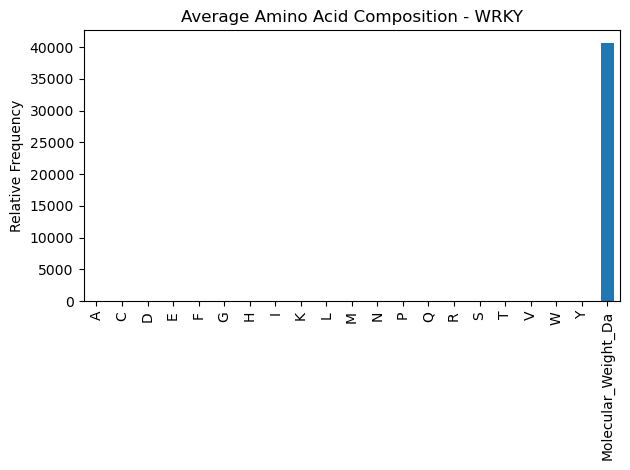

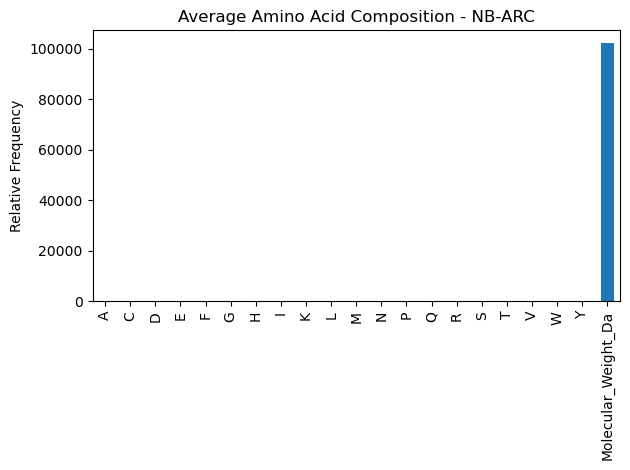

In [8]:
import matplotlib.pyplot as plt

# Average amino acid composition
df_wrky.mean().plot(kind='bar', title='Average Amino Acid Composition - WRKY')
plt.ylabel('Relative Frequency')
plt.tight_layout()
plt.show()

df_nbarc.mean().plot(kind='bar', title='Average Amino Acid Composition - NB-ARC')
plt.ylabel('Relative Frequency')
plt.tight_layout()
plt.show()


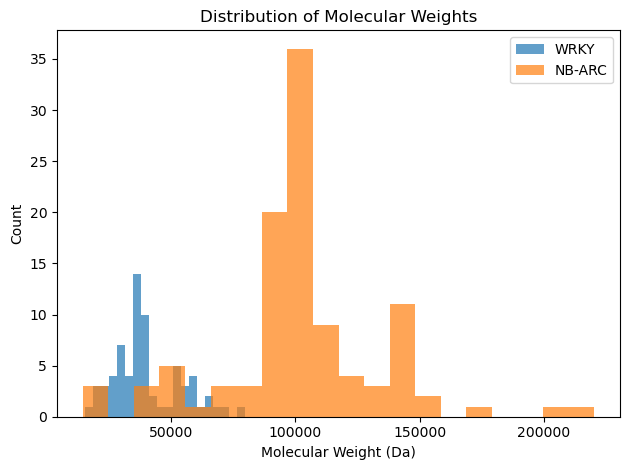

In [9]:
plt.hist(df_wrky["Molecular_Weight_Da"], bins=20, alpha=0.7, label="WRKY")
plt.hist(df_nbarc["Molecular_Weight_Da"], bins=20, alpha=0.7, label="NB-ARC")
plt.xlabel("Molecular Weight (Da)")
plt.ylabel("Count")
plt.title("Distribution of Molecular Weights")
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqUtils import molecular_weight
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


In [11]:
def extract_features(fasta_file, label=None):
    amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
    data = []

    for record in SeqIO.parse(fasta_file, "fasta"):
        seq = str(record.seq)
        if "X" in seq or len(seq) == 0:
            continue  # skip bad sequences

        analysis = ProteinAnalysis(seq)
        aa_count = Counter(seq)
        length = len(seq)

        features = {aa: aa_count.get(aa, 0) / length for aa in amino_acids}
        features["Molecular_Weight_Da"] = round(molecular_weight(seq, seq_type="protein"), 2)
        features["Isoelectric_Point"] = round(analysis.isoelectric_point(), 2)
        features["Instability_Index"] = round(analysis.instability_index(), 2)
        features["GRAVY"] = round(analysis.gravy(), 3)
        features["Aromaticity"] = round(analysis.aromaticity(), 3)
        features["Aliphatic_Index"] = round(analysis.aliphatic_index(), 2)
        features["ID"] = record.id

        if label is not None:
            features["Label"] = label

        data.append(features)

    df = pd.DataFrame(data)
    df.set_index("ID", inplace=True)
    return df


In [13]:
# features["Aliphatic_Index"] = round(analysis.aliphatic_index(), 2)


In [14]:
df_wrky.to_csv("wrky_features.csv")
df_nbarc.to_csv("nbarc_features.csv")


In [22]:
KeyError: "['Label'] not found in axis"


In [23]:
print("WRKY Columns:", df_wrky.columns)
print("NB-ARC Columns:", df_nbarc.columns)


WRKY Columns: Index(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q',
       'R', 'S', 'T', 'V', 'W', 'Y', 'Molecular_Weight_Da'],
      dtype='object')
NB-ARC Columns: Index(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q',
       'R', 'S', 'T', 'V', 'W', 'Y', 'Molecular_Weight_Da'],
      dtype='object')


In [24]:
df_wrky["Label"] = "WRKY"
df_nbarc["Label"] = "NB-ARC"


In [25]:
df_all = pd.concat([df_wrky, df_nbarc])
X = df_all.drop("Label", axis=1)
y = df_all["Label"]


In [27]:
# Fix missing labels (if you forgot to assign earlier)
df_wrky["Label"] = "WRKY"
df_nbarc["Label"] = "NB-ARC"

# Combine and define features/labels
df_all = pd.concat([df_wrky, df_nbarc])
X = df_all.drop("Label", axis=1)
y = df_all["Label"]


In [30]:
# STEP 1: Prepare your features and labels
df_wrky["Label"] = "WRKY"
df_nbarc["Label"] = "NB-ARC"
df_all = pd.concat([df_wrky, df_nbarc])

X = df_all.drop("Label", axis=1)
y = df_all["Label"]

# STEP 2: Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# STEP 3: Train the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

✅ Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

      NB-ARC       1.00      1.00      1.00        16
        WRKY       1.00      1.00      1.00        19

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35



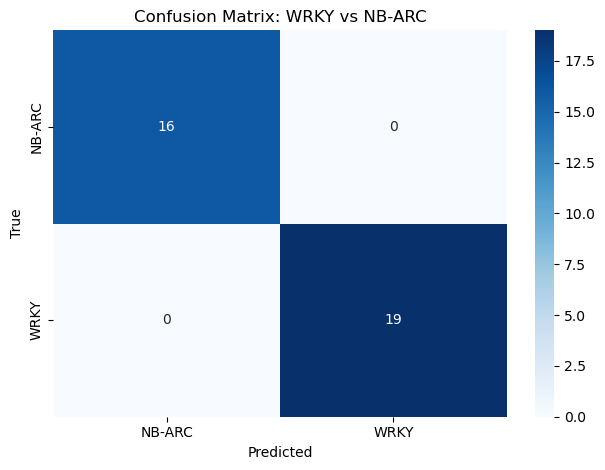

In [31]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

y_pred = model.predict(X_test)

print("✅ Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Optional: Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix: WRKY vs NB-ARC")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
